In [1]:
import pandas as pd
import re
import json
import matplotlib.pyplot as plt

In [2]:
#Read csv data
visitors_df=pd.read_csv('/content/visitors.csv')
answers_df=pd.read_csv('/content/visitors_answers.csv')
questions_df=pd.read_csv('/content/visitors_questions.csv')

Dataset Overview
1. Visitors (visitors.csv)
    *   email: Unique email identifier for visitors.
    *   gender : Visitor Gender
    *   id : Unique registration Id
    *   data: JSON data of answers selected during registration.

2. Answers (answers.csv)
    *   id: Unique identifier for an answer.
    *   questionid: The ID of the question this answer belongs to.
    *   answer: The text of the selected answer.

3. Questions (questions.csv)
    *   questionid: Unique identifier for a question.
    *   questionTypeId : Unique identifier for a question Type
    *   Step Id : Unique identifier for a question Step
    *   question: The text of the question.

4. Exhibitor Categories (exhibitor_categories.csv)
    *   categoryId: Unique identifier for an exhibitor category.
    *   categoryName: Description of the category.

5. Exhibitors (exhibitors.csv)
    *   exhibitorID: Unique identifier for an exhibitor.
    *   Name : Exhibitor Name
    *   MainCategories: Pipe-separated (|) list of categories selected by the exhibitor.


















**Understanding the table relations**

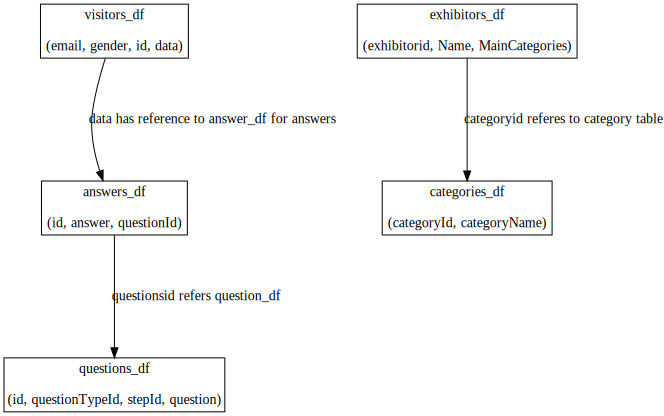

In [3]:
from graphviz import Digraph

dot = Digraph('Enity Relationships Diagram')

#adding nodes
dot.attr(ranksep='1.5', nodesep='1.5')
dot.node('V', 'visitors_df\n\n(email, gender, id, data)', shape='box')
dot.node('A', 'answers_df\n\n(id, answer, questionId)', shape='box')
dot.node('Q', 'questions_df\n\n(id, questionTypeId, stepId, question)', shape='box')
dot.node('C', 'categories_df\n\n(categoryId, categoryName)', shape='box')
dot.node('E', 'exhibitors_df\n\n(exhibitorid, Name, MainCategories)', shape='box')

#adding relations
dot.edge('V', 'A', label='data has reference to answer_df for answers')
dot.edge('A', 'Q', label='questionsid refers question_df')
dot.edge('E', 'C', label='categoryid referes to category table')

dot.render('ERD_with_squares', format='png', view=True)
dot


**Data Cleaning - Visitors and QnA dataframes**

In [6]:
# Create a mapping dictionary from questions_df and answer_df
question_dict = questions_df.set_index('id')['question'].to_dict()
answer_dict = answers_df.set_index('id')['answer'].to_dict()

In [7]:
#Expand visitors_df to breakdown the data column
visitors_df['data']=visitors_df['data'].apply(lambda x: json.loads(x))
visitors_df_expanded = visitors_df.explode('data').reset_index(drop=True)
visitors_df_normalized = pd.json_normalize(visitors_df_expanded['data']).reset_index(drop=True)
visitors_df_final = pd.concat([visitors_df_expanded.drop(columns=['data']).reset_index(drop=True), visitors_df_normalized], axis=1)

In [8]:
visitors_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2827 entries, 0 to 2826
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   email         2827 non-null   object
 1   gender        2827 non-null   object
 2   id            2827 non-null   object
 3   stepId        2827 non-null   object
 4   questionId    2827 non-null   object
 5   answerValue   2827 non-null   object
 6   answerId      2827 non-null   object
 7   answerTypeId  2827 non-null   object
dtypes: object(8)
memory usage: 176.8+ KB


In [9]:
# Replace the questionId in answers_df using the mapping dictionary
visitors_df_final['question'] = visitors_df_final['questionId'].map(question_dict)
visitors_df_final['answer'] = visitors_df_final['answerId'].map(answer_dict)

In [10]:
visitors_df_final.rename(columns={'id':'visitorId'},inplace=True)

In [11]:
#encode gender category
visitors_df_final['gender']=visitors_df_final['gender'].map({'F':0,'M':1})

In [12]:
visitors_df_final.tail()

,email,gender,visitorId,stepId,questionId,answerValue,answerId,answerTypeId,question,answer
2822,daniela.p+200_IzcX_CIHU@bss.com.mk,1,mv0j9yovwhgmtif9l1naciko,5c8a78336d41a10da4f73252,5c8a78336d41a10da4f73358,,5c8a78336d41a10da4f73359,Answer,NaN,NaN
2823,daniela.p+200_IzcX_CIHU@bss.com.mk,1,mv0j9yovwhgmtif9l1naciko,5c8a78336d41a10da4f73252,5c8a78336d41a10da4f732ed,,5c8a78336d41a10da4f732ee,Answer,NaN,NaN
2824,daniela.p+200_IzcX_CIHU@bss.com.mk,1,mv0j9yovwhgmtif9l1naciko,5c8a78336d41a10da4f7336c,5c8a78336d41a10da4f7336d,,5c8a78336d41a10da4f73370,Answer,What role do you play in the purchasing decisi...,Advisory role
2825,daniela.p+200_IzcX_CIHU@bss.com.mk,1,mv0j9yovwhgmtif9l1naciko,5c8a78336d41a10da4f7337a,5c8a78336d41a10da4f7337b,,5c8a78336d41a10da4f7337c,Answer,NaN,NaN
2826,daniela.p+200_IzcX_CIHU@bss.com.mk,1,mv0j9yovwhgmtif9l1naciko,5c8a78336d41a10da4f7337a,5c8a78336d41a10da4f7337e,,5c8a78336d41a10da4f7337f,Answer,NaN,NaN


In [13]:
#Remove rows where there are no answers
visitors_df_final.dropna(subset=['answer'],inplace=True)

In [14]:
visitors_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 14 to 2824
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   email         361 non-null    object
 1   gender        361 non-null    int64 
 2   visitorId     361 non-null    object
 3   stepId        361 non-null    object
 4   questionId    361 non-null    object
 5   answerValue   361 non-null    object
 6   answerId      361 non-null    object
 7   answerTypeId  361 non-null    object
 8   question      361 non-null    object
 9   answer        361 non-null    object
dtypes: int64(1), object(9)
memory usage: 31.0+ KB
